# <center> HMANet: Hybrid Multi-Axis Aggregation Network for Image Super-Resolution

<div style="text-align: justify;">
En este notebook se va a realizar un estudio experimental del método HMA-Net. El modelo HMA combina la atención de canales y la auto-atención, aprovechando la capacidad de percepción global de la atención de canales para compensar las limitaciones de la auto-atención. Además, introduce una novedosa red de agregación híbrida multiaxial (HMA), compuesta por bloques residuales híbridos Transformer (Residual Hybrid Transformer Blocks, RHTB) y bloques de atención por cuadrícula (Grid Attention Blocks, GAB). Esto agrega la posiblidad de considerar tanto campos receptivos locales como globales. También ayuda a modelar dependencias a distancia en las imágenes.
</div>

## Configuración del entorno de trabajo

Este notebook se ha hecho en un entorno local porque necesitaba unas versiones concretas de algunas librerias como son PyTorch y BasicSR. A continuación se importarán todas las librerias necesarias para el correcto funcionamiento del notebook.

In [6]:
# Importaciones estándar de Python
import os
import sys
import logging
import os.path as osp

# Manejo de imágenes y visualización
import PIL
import matplotlib
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Módulos específicos del proyecto HMA-Net
import hma.archs   # Define la arquitectura del modelo
import hma.data    # Define la carga y el preprocesamiento de los datos
import hma.models  # Define la construción y el entrenamiento del modelo

# Bibliotecas de PyTorch
import torch

# Funciones y utilidades de basicsr
import basicsr
from basicsr.data import build_dataloader, build_dataset
from basicsr.models import build_model
from basicsr.utils import get_env_info,get_root_logger,get_time_str,make_exp_dirs
from basicsr.utils.options import dict2str,parse_options

Las versiones de las bibliotecas que se utilizarán en el proceso. El uso de estas versiones garantiza la compatibilidad entre las diferentes bibliotecas para este proyecto

In [8]:
print("Versión de Python:", sys.version)
print("Versión de PyTorch:", torch.__version__)
print("Versión de BasicSR:", basicsr.__version__)
print("Versión de Pillow:", PIL.__version__)
print("Versión de Matplotlib:", matplotlib.__version__)

Versión de Python: 3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]
Versión de PyTorch: 1.9.1+cpu
Versión de BasicSR: 1.3.4.9
Versión de Pillow: 10.4.0
Versión de Matplotlib: 3.4.3


El proximo paso para terminar de configurar el entorno será definir la ruta absoluta del directorio actual para poder cargar diferentes archivos, como por ejemplo las imágenes.

In [10]:
# Definir la ruta al directorio raíz del proyecto de forma relativa
project_root = osp.join(os.getcwd())

# Cambiar el directorio de trabajo al directorio raíz del proyecto
os.chdir(project_root)
print("Directorio actual de trabajo:", os.getcwd())

# Añadir el directorio raíz al inicio de sys.path si no está ya presente
if project_root not in sys.path:
    sys.path.insert(0, project_root)

Directorio actual de trabajo: C:\Users\lbuln\OneDrive - UNIVERSIDAD DE SEVILLA\Escritorio\Modelo HMA\HMA


## Entrada del modelo

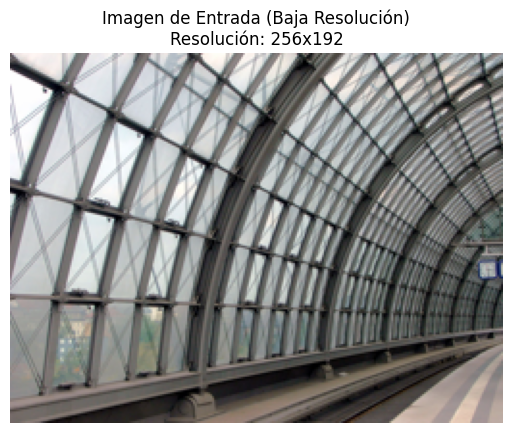

In [12]:
# Ruta a la imagen de entrada
imagen="img_001"
extension=".png"
imagen_original_path = f'datasets/test/LR/{imagen}{extension}'

# Cargar la imagen
img = Image.open(imagen_original_path)

# Obtener la resolución de la imagen
width, height = img.size

# Mostrar la imagen con la resolución en el título
plt.imshow(img)
plt.axis('off')  # Quitar los ejes
plt.title(f"Imagen de Entrada (Baja Resolución)\nResolución: {width}x{height}")
plt.show()

## Pruebas del modelo

In [14]:
def upscaler(config_path):
    # Parsear las opciones de configuración
    opt, _ = parse_options(config_path, is_train=False) 
        #is_train=False indica que el modelo se utiliza en modo de prueba, no para entrenamiento.
        #opt contiene las configuraciones del modelo, datos, y rutas necesarias para la ejecución.

    # Configura PyTorch para rendimiento
    torch.backends.cudnn.benchmark = True

    # Crea los directorios necesarios para el experimento.
    make_exp_dirs(opt)
    #log_file = osp.join(opt['path']['log'], f"test_{opt['name']}_{get_time_str()}.log")
    #logger = get_root_logger(logger_name='basicsr', log_level=logging.INFO, log_file=log_file)
        #activar para generar el archivo logger

    # Crea los datasets y dataloaders
    test_loaders = []
    for _, dataset_opt in sorted(opt['datasets'].items()):
        test_set = build_dataset(dataset_opt)  # Crea un conjunto de datos utilizando las opciones del archivo de configuración.
        test_loader = build_dataloader(        # Construye un dataloader, que maneja el procesamiento por lotes y la paralelización.
            test_set, dataset_opt, num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])
        test_loaders.append(test_loader)

    # Crea modelo
    model = build_model(opt)

    for test_loader in test_loaders:
        test_set_name = test_loader.dataset.opt['name']
        print(f'Mejorando la resolución ...')
        model.validation(test_loader, current_iter=opt['name'], tb_logger=None, save_img=opt['val']['save_img'])
        # Llama al método de validación para aplicarSR a cada imagen del dataloader
        print(f'Mejora finalizada.')

### *Pruebas de mejora x2*

In [16]:
# Guardar los argumentos originales
original_argv = sys.argv.copy()

# Simular los argumentos necesarios para las pruebas
sys.argv = [
    'hma/upscaler.py',
    '-opt',
    'options/test/HMA_SRx2.yml'  # Ruta al archivo de configuración
]

# Ejecutar pruebas
try:
    upscaler(osp.abspath('.'))
except SystemExit as e:
    print("El script ha terminado con el código de salida:", e.code)
finally:
    # Restaurar los argumentos originales
    sys.argv = original_argv

Disable distributed.
Path already exists. Rename it to C:\Users\lbuln\OneDrive - UNIVERSIDAD DE SEVILLA\Escritorio\Modelo HMA\HMA\results\HMA_test_X2_archived_20250123_124342
Mejorando la resolución ...
	Se ha procesado 1 mosaico de 1.
Mejora finalizada.


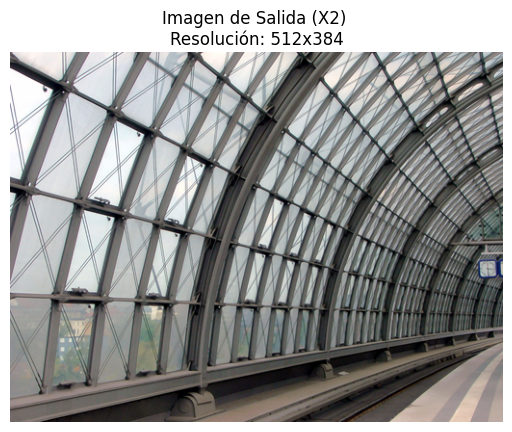

In [17]:
imagen_x2_path = f'results/HMA_test_X2/visualization/Prueba/{imagen}_HMA_test_X2.png'

# Cargar la imagen
img = Image.open(imagen_x2_path)

# Obtener la resolución de la imagen
width, height = img.size

# Mostrar la imagen con la resolución en el título
plt.imshow(img)
plt.axis('off')  # Quitar los ejes
plt.title(f"Imagen de Salida (X2) \nResolución: {width}x{height}")
plt.show()

### *Pruebas de mejora x3*

In [19]:
# Guardar los argumentos originales
original_argv = sys.argv.copy()

# Simular los argumentos necesarios para la prueba
sys.argv = [
    'hma/upscaler.py',
    '-opt',
    'options/test/HMA_SRx3.yml'  # Ruta al archivo de configuración
]

# Ejecutar la prueba
try:
    upscaler(osp.abspath('.'))
except SystemExit as e:
    print("El script ha terminado con el código de salida:", e.code)
finally:
    # Restaurar los argumentos originales
    sys.argv = original_argv

Disable distributed.
Path already exists. Rename it to C:\Users\lbuln\OneDrive - UNIVERSIDAD DE SEVILLA\Escritorio\Modelo HMA\HMA\results\HMA_test_X3_archived_20250123_124439
Mejorando la resolución ...
	Se ha procesado 1 mosaico de 1.
Mejora finalizada.


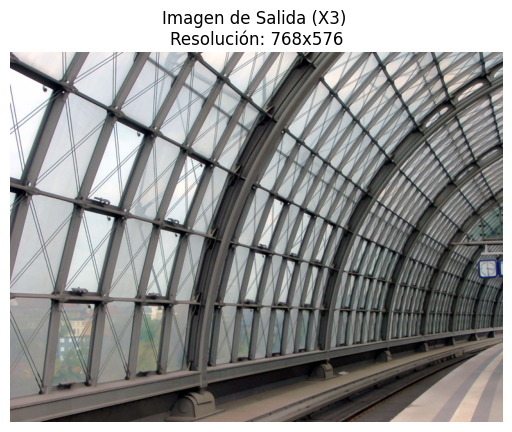

In [20]:
imagen_x3_path = f'results/HMA_test_X3/visualization/Prueba/{imagen}_HMA_test_X3.png'

# Cargar la imagen
img = Image.open(imagen_x3_path)

# Obtener la resolución de la imagen
width, height = img.size

# Mostrar la imagen con la resolución en el título
plt.imshow(img)
plt.axis('off')  # Quitar los ejes
plt.title(f"Imagen de Salida (X3) \nResolución: {width}x{height}")
plt.show()

### *Pruebas de mejora x4*

In [22]:
# Guardar los argumentos originales
original_argv = sys.argv.copy()

# Simular los argumentos necesarios para la prueba
sys.argv = [
    'hma/upscaler.py',
    '-opt',
    'options/test/HMA_SRx4.yml'  # Ruta al archivo de configuración
]

# Ejecutar la prueba
try:
    upscaler(osp.abspath('.'))
except SystemExit as e:
    print("El script ha terminado con el código de salida:", e.code)
finally:
    # Restaurar los argumentos originales
    sys.argv = original_argv

Disable distributed.
Path already exists. Rename it to C:\Users\lbuln\OneDrive - UNIVERSIDAD DE SEVILLA\Escritorio\Modelo HMA\HMA\results\HMA_test_X4_archived_20250123_124536
Mejorando la resolución ...
	Se ha procesado 1 mosaico de 1.
Mejora finalizada.


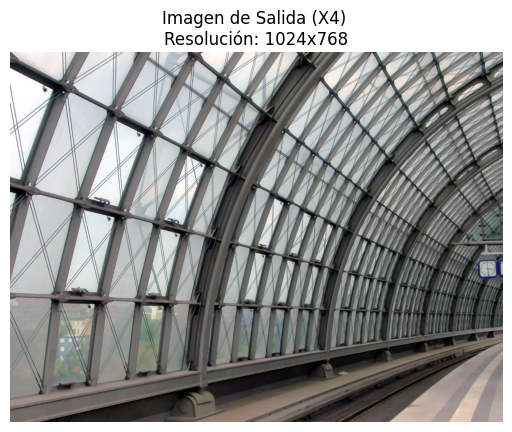

In [23]:
imagen_x4_path = f'results/HMA_test_X4/visualization/Prueba/{imagen}_HMA_test_X4.png'

# Cargar la imagen
img4 = Image.open(imagen_x4_path)

# Obtener la resolución de la imagen
width, height = img4.size

# Mostrar la imagen con la resolución en el título
plt.imshow(img4)
plt.axis('off')  # Quitar los ejes
plt.title(f"Imagen de Salida (X4) \nResolución: {width}x{height}")
plt.show()

### Comparación

En este apartado se compararán los resultados de las imagenes anteriores. Se hará una comparación de la imagen original en baja resolución comparada con las imagenes creadas con el modelo pre-entrenado.

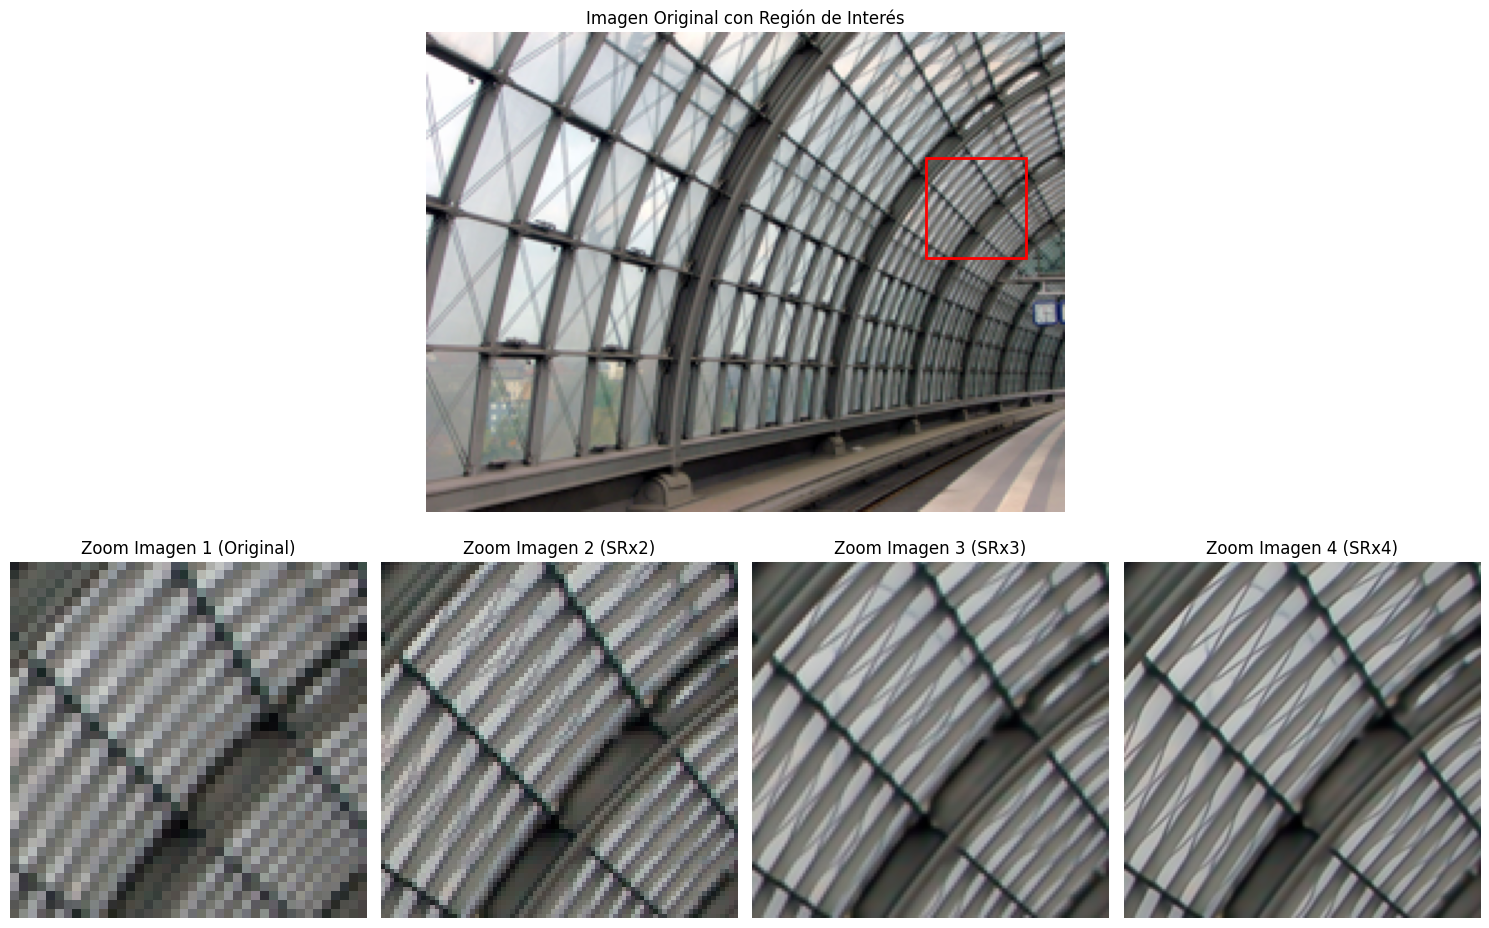

In [26]:
# Cargar las imágenes
img1 = np.array(Image.open(imagen_original_path).convert('RGB'))  # Baja resolución
img2 = np.array(Image.open(imagen_x2_path).convert('RGB'))  # SRx2
img3 = np.array(Image.open(imagen_x3_path).convert('RGB'))  # SRx2
img4 = np.array(Image.open(imagen_x4_path).convert('RGB'))  # SRx4

# Factores de escala entre las imágenes
scale_factor_2 = img2.shape[0] // img1.shape[0]  # Escala entre SRx2 y original
scale_factor_3 = img3.shape[0] // img1.shape[0]  # Escala entre SRx3 y original
scale_factor_4 = img4.shape[0] // img1.shape[0]  # Escala entre SRx4 y original

# Coordenadas de la región en la imagen de baja resolución (xmin, ymin, ancho, alto)
region_lr = (200, 50, 40, 40)  # Cambia según el área deseada
x_lr, y_lr, w_lr, h_lr = region_lr

# Escalar la región para las imágenes SRx2, SRx3 y SRx4
region_sr2 = (
    x_lr * scale_factor_2,
    y_lr * scale_factor_2,
    w_lr * scale_factor_2,
    h_lr * scale_factor_2,
)
x_sr2, y_sr2, w_sr2, h_sr2 = region_sr2

region_sr3 = (
    x_lr * scale_factor_3,
    y_lr * scale_factor_3,
    w_lr * scale_factor_3,
    h_lr * scale_factor_3,
)
x_sr3, y_sr3, w_sr3, h_sr3 = region_sr3

region_sr4 = (
    x_lr * scale_factor_4,
    y_lr * scale_factor_4,
    w_lr * scale_factor_4,
    h_lr * scale_factor_4,
)
x_sr4, y_sr4, w_sr4, h_sr4 = region_sr4

# Recortar las regiones de interés (ROI) de todas las imágenes
zoomed_img1 = img1[y_lr:y_lr+h_lr, x_lr:x_lr+w_lr]
zoomed_img2 = img2[y_sr2:y_sr2+h_sr2, x_sr2:x_sr2+w_sr2]
zoomed_img3 = img3[y_sr3:y_sr3+h_sr3, x_sr3:x_sr3+w_sr3]
zoomed_img4 = img4[y_sr4:y_sr4+h_sr4, x_sr4:x_sr4+w_sr4]

# Mostrar la imagen original y las ampliaciones en el formato solicitado
fig = plt.figure(figsize=(15, 10))

# Primera fila: Imagen original con el rectángulo
ax1 = fig.add_subplot(2, 1, 1)  # Primera fila
ax1.imshow(img1)
ax1.set_title("Imagen Original con Región de Interés")
ax1.axis('off')
rect_lr = plt.Rectangle((x_lr, y_lr), w_lr, h_lr, linewidth=2, edgecolor='red', facecolor='none')
ax1.add_patch(rect_lr)

# Segunda fila: Los cuatro zooms en una fila
for i, (zoom_img, title) in enumerate(
    [
        (zoomed_img1, "Zoom Imagen 1 (Original)"),
        (zoomed_img2, "Zoom Imagen 2 (SRx2)"),
        (zoomed_img3, "Zoom Imagen 3 (SRx3)"),
        (zoomed_img4, "Zoom Imagen 4 (SRx4)"),
    ]
):
    ax = fig.add_subplot(2, 4, i + 5)  # Segunda fila (4 columnas)
    ax.imshow(zoom_img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()
